###  Predict Iowa House Prices using Regression

In [1]:
#"Premature optimization is the root of all evil.." -Donald Knuth
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pprint
import joblib

pd.options.display.max_rows=350
pd.options.display.max_columns=350

#Models for parameter selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Pipeline and transformation functions

#transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

#ColumnTransformer applies different transformers to different columns
from sklearn.compose import ColumnTransformer

#sequentially applies listed transformers and a final estimator
from sklearn.pipeline import Pipeline

import time
start1 = time.time()

In [3]:
#****************************************Target Encoder******************************************
from category_encoders.target_encoder import TargetEncoder

def target_encode_categ(encode_cols, train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and 
    (2) "Prior": ExpectedVal(Target) over all training data.  
    
    Sets testTarget to NaN to stop data leakage.
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more parameters.'''
    
    trn=train.copy(); tst=test.copy();
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test

In [4]:
#Fetch data
train1=pd.read_csv('data/train.csv')
test1=pd.read_csv('data/test.csv')
train=train1.copy()
test=test1.copy()

In [5]:
train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [6]:
print('train:')
train.head(3)

train:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
from scipy import stats
from scipy.stats import norm
from scipy.stats import yeojohnson  #input must be float64

def normalize_feature(df, bad_feature):

    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
    lamYJ = 2            #dummy value for function to return
    #log_feat, lamYJ = yeojohnson(np.array(df[bad_feature]))
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat, lamYJ

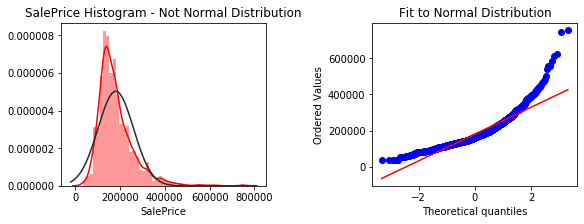

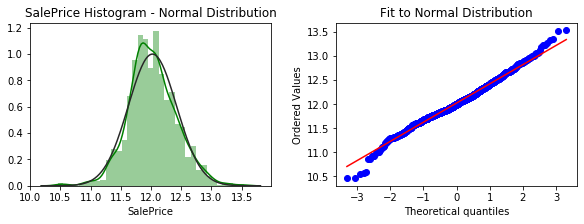

In [8]:
#Normalize SalePrice.  Johnson transform must be float64. lamYJ required so tranform can be undone.
#train['SalePrice']=train['SalePrice'].astype('float64')
train['SalePrice'], lamYJ = normalize_feature(df=train, bad_feature='SalePrice')
#train['SalePrice'], lamYJ = normalize_feature(df=train, bad_feature='SalePrice')

In [9]:
#COMBINE train/test for cleaning.  A data issue can be unique to one csv, like a different class type for a feature.
#train Id: 1-1460.  test Id: 1461-2919.
comb=train.append(test, ignore_index=True, sort=False).copy()  #Id identifies the observation rows
print('Orig comb shape:', comb.shape)

Orig comb shape: (2919, 81)


In [10]:
print('comb:')
comb.tail(3)

comb:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


### Data Cleaning

In [11]:
#Replace feature nans.  MSZoning fixed separately.
nan_dict={
            'Alley' : {np.nan : 'None'},
            'BsmtCond' : {np.nan : 'None'},
            'BsmtExposure' : {np.nan : 'None'},
            'BsmtFinSF1' : {np.nan : 0},
            'BsmtFinSF2' : {np.nan : 0},
            'BsmtFinType1' : {np.nan : 'None'},
            'BsmtFinType2' : {np.nan : 'None'},
            'BsmtFullBath' : {np.nan : 0},
            'BsmtHalfBath' : {np.nan : 0},
            'BsmtQual' : {np.nan : 'None'},
            'BsmtUnfSF' : {np.nan : 0},
            'Electrical' : {np.nan : 'SBrkr'},
            'Exterior1st' : {np.nan : 'VinylSd'},
            'Exterior2nd' : {np.nan : 'VinylSd'},
            'Fence' : {np.nan : 'None'},
            'FireplaceQu' : {np.nan : 'None'},
            'Functional' : {np.nan : 'Typ'},
            'GarageArea' : {np.nan : 0},
            'GarageCars' : {np.nan : 0},               #If omitted, probably zero.
            'GarageCond' : {np.nan : 'None'},
            'GarageFinish' : {np.nan : 'None'},
            'GarageQual' : {np.nan : 'None'},
            'GarageType' : {np.nan : 'None'},
            'KitchenQual' : {np.nan : 'TA'},
            'MasVnrArea' : {np.nan : 0},
            'MasVnrType' : {np.nan : 'None'},
            'MiscFeature' : {np.nan : 'None'},
            'PoolQC' : {np.nan : 'None'},
            'SaleType' : {np.nan : 'WD'},
            'TotalBsmtSF' : {np.nan : 0},
            'Utilities' : {np.nan : 'AllPub'}
        }

comb.replace(nan_dict, inplace=True)

In [12]:
#Inverse Yeo Yohnson transformation.  Possible alternative to natural log.
def reverse_yj_tranform(y, lam):
    '''
    Undo Yeo Johnson transform.  x was transformed to y.  Handles
    x >= 0 scenarios only.  x<0 must be derived.
    '''
    if lam != 0:   #for x >= 0 and lam != 0 case
        pwr=np.log((lam*y+1))/lam        
        return np.exp(pwr)
    elif lam == 0:   #for x >= 0 and lam = 0 case
        return np.exp(y) - 1

In [13]:
def custom_imputer(train_df, repl_df, cat_col, stati_col, stati_string, repl_on=False):
    '''
    View stati_col stat (Ex. 'mean') aggregated by each category in the 
    cat_col. Stats are based on train.  Use ONLY train to avoid leakage.
    Optionally, replace NaNs in the stati_col by setting repl_on = True.
    repl_df is the dataframe where NaNs will be replaced.
    '''
    repl_df1=repl_df.copy()   #work on copy so original dataframe is untouched
    stat_dict={}
    categories = sorted(train_df[cat_col].dropna().unique())
    for category in categories:   #get the stat value for each category key        
        if stati_string == 'mean':
            cat_train_df = train_df[train_df[cat_col] == category]
            stat_dict[category] = cat_train_df[stati_col].mean(skipna=True)            
        elif stati_string == 'median':
            cat_train_df = train_df[train_df[cat_col] == category]
            stat_dict[category] = cat_train_df[stati_col].median(skipna=True)
        elif stati_string == 'mode':
            cat_train_df = train_df[train_df[cat_col] == category]
            try:
                stat_dict[category] = cat_train_df[stati_col].mode(dropna=True)[0]
            except:
                print(f'{stati_col} in {category} likely NaN, causing indexing error. Set stat_dict val to np.nan.')
                stat_dict[category] = np.nan
        else:
            print("Invalid stati_string.  Must use 'mean', 'median', or 'mode'.")          
    
    print(f"stat_dict format - '{cat_col}' : {stati_col} '{stati_string}'"), print('--------------------------------------------') 
    print(stat_dict)
    print(f'\n### repl_df BEFORE ###: "{stati_col}" NaNs:')
    display(repl_df1[repl_df1[stati_col].isna()])

    indices_of_replaced=repl_df1[repl_df1[stati_col].isna()].index  #record indices of NaN rows   
    if repl_on == True:
        #fill category NaN with stat from stat_dict.
        for category in categories:
            repl_df1.loc[repl_df1[cat_col] == category, stati_col]=\
            repl_df1.loc[repl_df1[cat_col] == category, stati_col].fillna(stat_dict[category])
        #show repl_df1 replacement values that were formerly NaN    
        print(f'\n### repl_df AFTER ###: "{stati_col}" NaNs filled per stat_dict:')
        display(repl_df1.iloc[indices_of_replaced])
    return repl_df1

In [14]:
#Replace MSZoning NaNs with MSZoning mode by Neighborhood.  Save result to 'comb'.
comb=custom_imputer(train_df=train, repl_df=comb, cat_col='Neighborhood', stati_col='MSZoning',
                         stati_string='mode', repl_on=True)

stat_dict format - 'Neighborhood' : MSZoning 'mode'
--------------------------------------------
{'Blmngtn': 'RL', 'Blueste': 'RM', 'BrDale': 'RM', 'BrkSide': 'RM', 'ClearCr': 'RL', 'CollgCr': 'RL', 'Crawfor': 'RL', 'Edwards': 'RL', 'Gilbert': 'RL', 'IDOTRR': 'RM', 'MeadowV': 'RM', 'Mitchel': 'RL', 'NAmes': 'RL', 'NPkVill': 'RL', 'NWAmes': 'RL', 'NoRidge': 'RL', 'NridgHt': 'RL', 'OldTown': 'RM', 'SWISU': 'RL', 'Sawyer': 'RL', 'SawyerW': 'RL', 'Somerst': 'FV', 'StoneBr': 'RL', 'Timber': 'RL', 'Veenker': 'RL'}

### repl_df BEFORE ###: "MSZoning" NaNs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,NaN,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,NaN,NaN,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,NaN,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN



### repl_df AFTER ###: "MSZoning" NaNs filled per stat_dict:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RM,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,NaN,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN


In [15]:
#Replace LotFrontage NaNs with median by Neighborhood.  Save result to 'comb'.
comb=custom_imputer(train_df=train, repl_df=comb, cat_col='Neighborhood', stati_col='LotFrontage',
                         stati_string='median', repl_on=True)

stat_dict format - 'Neighborhood' : LotFrontage 'median'
--------------------------------------------
{'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 52.0, 'ClearCr': 80.0, 'CollgCr': 70.0, 'Crawfor': 74.0, 'Edwards': 65.5, 'Gilbert': 65.0, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 73.0, 'NAmes': 73.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 91.0, 'NridgHt': 88.5, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 71.0, 'SawyerW': 66.5, 'Somerst': 73.5, 'StoneBr': 61.5, 'Timber': 85.0, 'Veenker': 68.0}

### repl_df BEFORE ###: "LotFrontage" NaNs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,12.206078
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737.0,Unf,0.0,175.0,912.0,GasA,TA,Y,SBrkr,912,0,0,912,1.0,0.0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1.0,352.0,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,11.877576
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733.0,Unf,0.0,520.0,1253.0,GasA,TA,Y,SBrkr,1253,0,0,1253,1.0,0.0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1.0,352.0,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,11.964007
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,11.911708
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,11.944714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,2848,20,RL,NaN,11088,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2002,2002,Hip,CompShg,Stucco,Stucco,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,872.0,Unf,0.0,476.0,1348.0,GasA,Ex,Y,SBrkr,1358,0,0,1358,1.0,0.0,1,1,1,1,Gd,5,Typ,1,TA,Attchd,2002.0,Unf,2.0,418.0,TA,TA,Y,68,166,0,0,0,0,None,None,None,0,6,2006,WD,Normal,NaN
2850,2851,60,RL,NaN,21533,Pave,None,IR2,Lvl,AllPub,FR2,Gtl,CollgCr,Feedr,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1065.0,1065.0,GasA,Ex,Y,SBrkr,1065,984,0,2049,0.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,1997.0,Unf,2.0,467.0,TA,TA,Y,120,48,0,0,0,0,None,None,None,0,8,2006,WD,Normal,NaN
2900,2901,20,RL,NaN,50102,Pave,None,IR1,Low,AllPub,Inside,Mod,Timber,Norm,Norm,1Fam,1Story,6,5,1958,1958,Gable,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,909.0,Unf,0.0,723.0,1632.0,GasA,TA,Y,SBrkr,1650,0,0,1650,1.0,0.0,1,0,2,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,2.0,518.0,TA,TA,Y,0,0,0,0,138,0,None,None,None,0,3,2006,WD,Alloca,NaN
2901,2902,20,RL,NaN,8098,Pa


### repl_df AFTER ###: "LotFrontage" NaNs filled per stat_dict:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,80.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,12.206078
12,13,20,RL,71.0,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737.0,Unf,0.0,175.0,912.0,GasA,TA,Y,SBrkr,912,0,0,912,1.0,0.0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1.0,352.0,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,11.877576
14,15,20,RL,73.0,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733.0,Unf,0.0,520.0,1253.0,GasA,TA,Y,SBrkr,1253,0,0,1253,1.0,0.0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1.0,352.0,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,11.964007
16,17,20,RL,73.0,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,11.911708
24,25,20,RL,71.0,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,11.944714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,2848,20,RL,70.0,11088,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2002,2002,Hip,CompShg,Stucco,Stucco,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,872.0,Unf,0.0,476.0,1348.0,GasA,Ex,Y,SBrkr,1358,0,0,1358,1.0,0.0,1,1,1,1,Gd,5,Typ,1,TA,Attchd,2002.0,Unf,2.0,418.0,TA,TA,Y,68,166,0,0,0,0,None,None,None,0,6,2006,WD,Normal,NaN
2850,2851,60,RL,70.0,21533,Pave,None,IR2,Lvl,AllPub,FR2,Gtl,CollgCr,Feedr,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1065.0,1065.0,GasA,Ex,Y,SBrkr,1065,984,0,2049,0.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,1997.0,Unf,2.0,467.0,TA,TA,Y,120,48,0,0,0,0,None,None,None,0,8,2006,WD,Normal,NaN
2900,2901,20,RL,85.0,50102,Pave,None,IR1,Low,AllPub,Inside,Mod,Timber,Norm,Norm,1Fam,1Story,6,5,1958,1958,Gable,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,909.0,Unf,0.0,723.0,1632.0,GasA,TA,Y,SBrkr,1650,0,0,1650,1.0,0.0,1,0,2,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,2.0,518.0,TA,TA,Y,0,0,0,0,138,0,None,None,None,0,3,2006,WD,Alloca,NaN
2901,2902,20,RL,85.

In [16]:
comb.loc[[1915,2216,2250,2904]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RM,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,60.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN


In [17]:
#In test, fix garage attributes for 360 sq ft garage.  This is unfixable in a streaming data model.  Not the case here.
comb.loc[[2126], 'GarageFinish']=['Unf']
comb.loc[[2126], 'GarageQual']=['TA']
comb.loc[[2126], 'GarageCond']=['TA']
comb.loc[[2126]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2126,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,Unf,1.0,360.0,TA,TA,Y,64,0,180,0,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal,NaN


In [18]:
#Engineer Features part 1.
comb['TOT_SF'] = comb['1stFlrSF'] + comb['2ndFlrSF'] +comb['TotalBsmtSF']
comb['House_Age']=comb['YrSold']-comb['YearBuilt']
comb['Yrs_Since_Remod']=comb['YrSold']-comb['YearRemodAdd']

print('Issue with new features - negative values')
comb.loc[comb['Yrs_Since_Remod'] < 0, ['YearBuilt','YearRemodAdd','YrSold','House_Age','Yrs_Since_Remod']]

Issue with new features - negative values


,YearBuilt,YearRemodAdd,YrSold,House_Age,Yrs_Since_Remod
523,2007,2008,2007,0,-1
2295,2007,2008,2007,0,-1
2549,2008,2009,2007,-1,-2


In [19]:
#Assume negative value means new.  Replace negative with zero.
comb=comb.replace({'Yrs_Since_Remod': {-1 : 0, -2: 0},'House_Age': {-1 : 0}})

In [20]:
comb.loc[[523,2295,2549], ['YearBuilt','YearRemodAdd','YrSold','House_Age','Yrs_Since_Remod']]

,YearBuilt,YearRemodAdd,YrSold,House_Age,Yrs_Since_Remod
523,2007,2008,2007,0,0
2295,2007,2008,2007,0,0
2549,2008,2009,2007,0,0


In [21]:
#https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1#House-Prices:-Advanced-Regression-Techniques

#Engineer features part 2
comb['Total_Bathrooms']=comb['FullBath'] + 0.5*comb['HalfBath'] + comb['BsmtFullBath'] + 0.5*comb['BsmtHalfBath']
comb['Total_Porch_SF'] = (comb['OpenPorchSF'] + comb['3SsnPorch'] + comb['EnclosedPorch'] + 
                          comb['ScreenPorch'] + comb['WoodDeckSF'])

#Engineer binary features.
comb['haspool'] = comb['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
comb['has2ndfloor'] = comb['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
comb['hasbsmt'] = comb['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
comb['hasgarage'] = comb['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
comb['hasfireplace'] = comb['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
#Dump newly redundant features from engineering.
comb.drop(columns=['YrSold','YearBuilt','YearRemodAdd','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
                   'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF'],
                   axis='columns', inplace=True, errors='ignore')

#dump GarageYrBlt - too many nans and redundant
comb.drop(['GarageYrBlt'], axis=1, inplace=True, errors='ignore')

comb: (2919, 78)


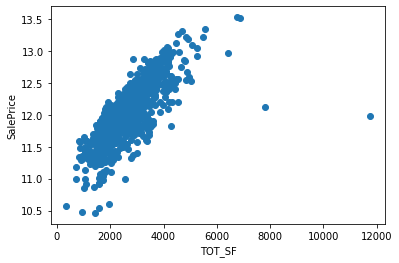

In [23]:
#Plot train ONLY to review SalePrice outliers
print('comb:', comb.shape)
train2=comb.loc[0:1459].copy()
plt.scatter(train2.TOT_SF, train2.SalePrice)
plt.xlabel('TOT_SF')
plt.ylabel('SalePrice')
plt.show()

In [24]:
#drop outliers from comb (not train)
outliers=train2[train2['TOT_SF']>6900].copy()
display(outliers.loc[:,['Id','TOT_SF','SalePrice']])
comb=comb.drop(index=outliers.index,errors='ignore')
print('comb:', comb.shape)

,Id,TOT_SF,SalePrice
523,524,7814.0,12.126764
1298,1299,11752.0,11.982935


comb: (2917, 78)


In [25]:
#Engineer MoSold
MS_dict={'MoSold': {12: 'Winter',
                  1: 'Winter',
                  2: 'Winter',
                  3: 'Spring',
                  4: 'Spring',
                  5: 'Spring',
                  6: 'Summer',
                  7: 'Summer',
                  8: 'Summer',
                  9: 'Fall',
                  10: 'Fall',
                  11: 'Fall'}}

comb.replace(MS_dict, inplace=True)

In [26]:
#Code ordinal features as numbers.
ord_coding={
        'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'ExterCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'HeatingQC' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'KitchenQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'LandContour' : {'Lvl': 1, 'Bnk': 2, 'HLS':3, 'Low': 0},
        'BsmtFinType1' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ':1,"Unf":1, "None": 0},
        'BsmtFinType2' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ':1,"Unf":1, "None": 0},
        'GarageFinish' : {'Fin': 3, 'RFn': 2, 'Unf':1, 'None':2},
        'PavedDrive' : {'Y': 3, 'P': 2, 'N':1},
        'Functional' : {'Typ':7, 'Min2':6, 'Min1':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
       }

comb.replace(ord_coding, inplace=True)

#Convert categorical features to numbers.
cat_feat_to_num = list(ord_coding.keys())
print(cat_feat_to_num)
for c in cat_feat_to_num:
    comb[c]=comb[c].astype('int64')

['ExterQual', 'BsmtCond', 'BsmtQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'LandContour', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'PavedDrive', 'Functional']


In [27]:
#Engineer features part 3a.  Combine collinear features to make better features (higher correlation to target).
#Weights are empirically-derived from train only to avoid train-test contamination.
   
comb['ExterQC'] = 0.93*comb['ExterQual'] + 0.07*comb['ExterCond']
comb['GarageQC'] = 0.7*comb['GarageQual'] + 0.3*comb['GarageCond']
comb.drop(columns=['ExterQual','ExterCond','GarageQual','GarageCond'], axis='columns', inplace=True, errors='ignore')

#GarageArea is collinear and redundant with GarageCars.
comb.drop(columns=['GarageArea'], axis='columns', inplace=True, errors='ignore')

In [28]:
#Engineer features part 3b.  Insert top poly features per train.

def get_parsed_dict(string):
    import re
    patt='(\w+)\^*(\d*)'
    parsed = re.findall(patt, string)
    feat_and_pwr={}
    for i in range(0,len(parsed)):
        if len(parsed[i][1]) > 0:
            feat_and_pwr[parsed[i][0]] = int(parsed[i][1])
        else:
            feat_and_pwr[parsed[i][0]] = 1
    return feat_and_pwr 

#Get dictionary of top poly features derived from get_polyfeatures function.
corrtrn=joblib.load('data/corrtrn.joblib')
polyDict={}
for row in corrtrn['feature'][0:10]:
    polyDict[row] = get_parsed_dict(row)

#Add to dataframe.
for tup in polyDict.items():    
    for idx, row in enumerate(tup[1].items()):
        if idx == 0:
            comb[tup[0]] = comb[row[0]]**row[1]            
        else:
            comb[tup[0]] *= comb[row[0]]**row[1] 

# #Visualize top 10 poly features in comb.
# important=list(corrtrn['feature'].values[0:10])
# sp_list=['SalePrice' for i in range(0,10)]
# for row in zip(important, sp_list):
#     plot=sns.jointplot(x=row[0], y=row[1], data=comb, kind='scatter')    
#     plt.show()            

In [29]:
comb.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasbsmt,hasgarage,hasfireplace,ExterQC,GarageQC,OverallQual TOT_SF,KitchenQual TOT_SF,TOT_SF ExterQC,BsmtQual TOT_SF,OverallQual GrLivArea,OverallQual Total_Bathrooms,HeatingQC TOT_SF,Functional TOT_SF,BsmtQual GrLivArea,GarageCars TOT_SF
2914,2915,160,RM,21.0,1936,Pave,None,Reg,1,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,Gable,CompShg,CemntBd,CmentBd,None,0.0,CBlock,3,3,No,1,0.0,1,0.0,546.0,546.0,GasA,4,Y,SBrkr,546,546,0,1092,3,1,3,5,7,0,None,None,2,0.0,3,0,None,None,None,0,Summer,WD,Normal,NaN,1638.0,36,36,1.5,0,0,1,1,0,0,3.0,0.0,6552.0,4914.0,4914.0,4914.0,4368,6.0,6552.0,11466.0,3276,0.0
2915,2916,160,RM,21.0,1894,Pave,None,Reg,1,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,None,0.0,CBlock,3,3,No,2,252.0,1,0.0,294.0,546.0,GasA,3,Y,SBrkr,546,546,0,1092,3,1,3,6,7,0,None,CarPort,1,1.0,3,0,None,None,None,0,Spring,WD,Abnorml,NaN,1638.0,36,36,1.5,24,0,1,1,1,0,3.0,3.0,6552.0,4914.0,4914.0,4914.0,4368,6.0,4914.0,11466.0,3276,1638.0
2916,2917,20,RL,160.0,20000,Pave,None,Reg,1,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,CBlock,3,3,No,2,1224.0,1,0.0,0.0,1224.0,GasA,5,Y,SBrkr,1224,0,0,1224,4,1,3,7,7,1,TA,Detchd,1,2.0,3,0,None,None,None,0,Fall,WD,Abnorml,NaN,2448.0,46,10,2.0,474,0,0,1,1,1,3.0,3.0,12240.0,7344.0,7344.0,7344.0,6120,10.0,12240.0,17136.0,3672,4896.0
2917,2918,85,RL,62.0,10441,Pave,None,Reg,1,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,Gable,CompShg,HdBoard,Wd Shng,None,0.0,PConc,4,3,Av,3,337.0,1,0.0,575.0,912.0,GasA,3,Y,SBrkr,970,0,0,970,3,1,3,6,7,0,None,None,2,0.0,3,0,None,MnPrv,Shed,700,Summer,WD,Normal,NaN,1882.0,14,14,1.5,112,0,0,1,0,0,3.0,0.0,9410.0,5646.0,5646.0,7528.0,4850,7.5,5646.0,13174.0,3880,0.0
2918,2919,60,RL,74.0,9627,Pave,None,Reg,1,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,PConc,4,3,Av,1,758.0,1,0.0,238.0,996.0,GasA,5,Y,SBrkr,996,1004,0,2000,3,1,3,9,7,1,TA,Attchd,3,3.0,3,0,None,None,None,0,Fall,WD,Normal,NaN,2996.0,13,12,2.5,238,0,1,1,1,1,3.0,3.0,20972.0,8988.0,8988.0,11984.0,14000,17.5,14980.0,20972.0,8000,8988.0


In [30]:
#Numeric feature is really a category.  Convert.
true_cat = ['MSSubClass']
for c in true_cat:
    comb[c]=comb[c].astype('object')

### From comb, restore train/test

In [31]:
#First, set comb 'Id' as dataframe index
comb.set_index('Id', inplace=True)

#Restore train and test from comb
train=comb.loc[0:1460].copy()
test=comb.loc[1461:].copy()
display(train.tail(2)); display(test.head(2));

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasbsmt,hasgarage,hasfireplace,ExterQC,GarageQC,OverallQual TOT_SF,KitchenQual TOT_SF,TOT_SF ExterQC,BsmtQual TOT_SF,OverallQual GrLivArea,OverallQual Total_Bathrooms,HeatingQC TOT_SF,Functional TOT_SF,BsmtQual GrLivArea,GarageCars TOT_SF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1459,20,RL,68.0,9717,Pave,None,Reg,1,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,Hip,CompShg,MetalSd,MetalSd,None,0.0,CBlock,3,3,Mn,3,49.0,2,1029.0,0.0,1078.0,GasA,4,Y,FuseA,1078,0,0,1078,2,1,4,5,7,0,None,Attchd,1,1.0,3,0,None,None,None,0,Spring,WD,Normal,11.864469,2156.0,60,14,2.0,478,0,0,1,1,0,3.00,3.0,10780.0,8624.0,6468.00,6468.0,5390,10.0,8624.0,15092.0,3234,2156.0
1460,20,RL,75.0,9937,Pave,None,Reg,1,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,Gable,CompShg,HdBoard,HdBoard,None,0.0,CBlock,3,3,No,1,830.0,1,290.0,136.0,1256.0,GasA,4,Y,SBrkr,1256,0,0,1256,3,1,3,6,7,0,None,Attchd,3,1.0,3,0,None,None,None,0,Summer,WD,Normal,11.901590,2512.0,43,43,2.5,804,0,0,1,1,0,3.93,3.0,12560.0,7536.0,9872.16,7536.0,6280,12.5,10048.0,17584.0,3768,2512.0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasbsmt,hasgarage,hasfireplace,ExterQC,GarageQC,OverallQual TOT_SF,KitchenQual TOT_SF,TOT_SF ExterQC,BsmtQual TOT_SF,OverallQual GrLivArea,OverallQual Total_Bathrooms,HeatingQC TOT_SF,Functional TOT_SF,BsmtQual GrLivArea,GarageCars TOT_SF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,1,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,0.0,CBlock,3,3,No,2,468.0,1,144.0,270.0,882.0,GasA,3,Y,SBrkr,896,0,0,896,2,1,3,5,7,0,None,Attchd,1,1.0,3,0,None,MnPrv,None,0,Summer,WD,Normal,NaN,1778.0,49,49,1.0,260,0,0,1,1,0,3.0,3.0,8890.0,5334.0,5334.0,5334.0,4480,5.0,5334.0,12446.0,2688,1778.0
1462,20,RL,81.0,14267,Pave,None,IR1,1,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,CBlock,3,3,No,2,923.0,1,0.0,406.0,1329.0,GasA,3,Y,SBrkr,1329,0,0,1329,3,1,4,6,7,0,None,Attchd,1,1.0,3,0,None,None,Gar2,12500,Summer,WD,Normal,NaN,2658.0,52,52,1.5,429,0,0,1,1,0,3.0,3.0,15948.0,10632.0,7974.0,7974.0,7974,9.0,7974.0,18606.0,3987,2658.0


In [32]:
print('Train feature correlations to SalePrice:\n')
train.corr()['SalePrice'].sort_values(ascending=False).round(4)

Train feature correlations to SalePrice:



SalePrice                      1.0000
OverallQual TOT_SF             0.8829
KitchenQual TOT_SF             0.8661
TOT_SF ExterQC                 0.8634
BsmtQual TOT_SF                0.8562
OverallQual GrLivArea          0.8384
OverallQual Total_Bathrooms    0.8300
HeatingQC TOT_SF               0.8295
Functional TOT_SF              0.8285
BsmtQual GrLivArea             0.8282
GarageCars TOT_SF              0.8278
TOT_SF                         0.8253
OverallQual                    0.8214
GrLivArea                      0.7252
ExterQC                        0.6835
GarageCars                     0.6810
Total_Bathrooms                0.6767
KitchenQual                    0.6700
TotalBsmtSF                    0.6476
1stFlrSF                       0.6205
BsmtQual                       0.6169
TotRmsAbvGrd                   0.5377
hasfireplace                   0.5103
GarageFinish                   0.4963
Fireplaces                     0.4920
HeatingQC                      0.4739
MasVnrArea  

In [33]:
# def get_polyfeatures(train, target, numer_cols, degree=2, top_X=5, bottom_X=5):
#     '''
#     Returns top feature correlations as DataFrame.
#     '''
#     from sklearn.preprocessing import PolynomialFeatures
#     poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
#     ptrn = train[numer_cols].copy()
#     ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
#     print('Transformed train shape:', ptrn.shape)
       
#     #Get top correlation dataframe and top features list. 
#     corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1][0]] for c in ptrn.columns]
#     corrtrn=pd.DataFrame(data=corrList, columns=['feature','corr']).sort_values(by='corr', ascending=False).dropna().reset_index(drop=True)
#     corrtrn = corrtrn.iloc[np.r_[0:top_X, -bottom_X:0]]
#     return corrtrn

# num_feat=[col for col in train.select_dtypes(exclude='object').columns]; 
# num_feat.remove('SalePrice');

# #Get top poly features - apply before transforms.
# corrtrn = get_polyfeatures(train=train, target='SalePrice', numer_cols=num_feat, degree=2, top_X=10, bottom_X=5)
# joblib.dump(corrtrn, 'data/corrtrn.joblib', compress=2)

In [34]:
#corrtrn

In [35]:
comb.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasbsmt,hasgarage,hasfireplace,ExterQC,GarageQC,OverallQual TOT_SF,KitchenQual TOT_SF,TOT_SF ExterQC,BsmtQual TOT_SF,OverallQual GrLivArea,OverallQual Total_Bathrooms,HeatingQC TOT_SF,Functional TOT_SF,BsmtQual GrLivArea,GarageCars TOT_SF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,1,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,PConc,4,3,No,3,706.0,1,0.0,150.0,856.0,GasA,5,Y,SBrkr,856,854,0,1710,3,1,4,8,7,0,None,Attchd,2,2.0,3,0,None,None,None,0,Winter,WD,Normal,12.247699,2566.0,5,5,3.5,61,0,1,1,1,0,3.93,3.0,17962.0,10264.0,10084.38,10264.0,11970,24.5,12830.0,17962.0,6840,5132.0
2,20,RL,80.0,9600,Pave,None,Reg,1,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,CBlock,4,3,Gd,2,978.0,1,0.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,0,0,1262,3,1,3,6,7,1,TA,Attchd,2,2.0,3,0,None,None,None,0,Spring,WD,Normal,12.109016,2524.0,31,31,2.5,298,0,0,1,1,1,3.00,3.0,15144.0,7572.0,7572.00,10096.0,7572,15.0,12620.0,17668.0,5048,5048.0


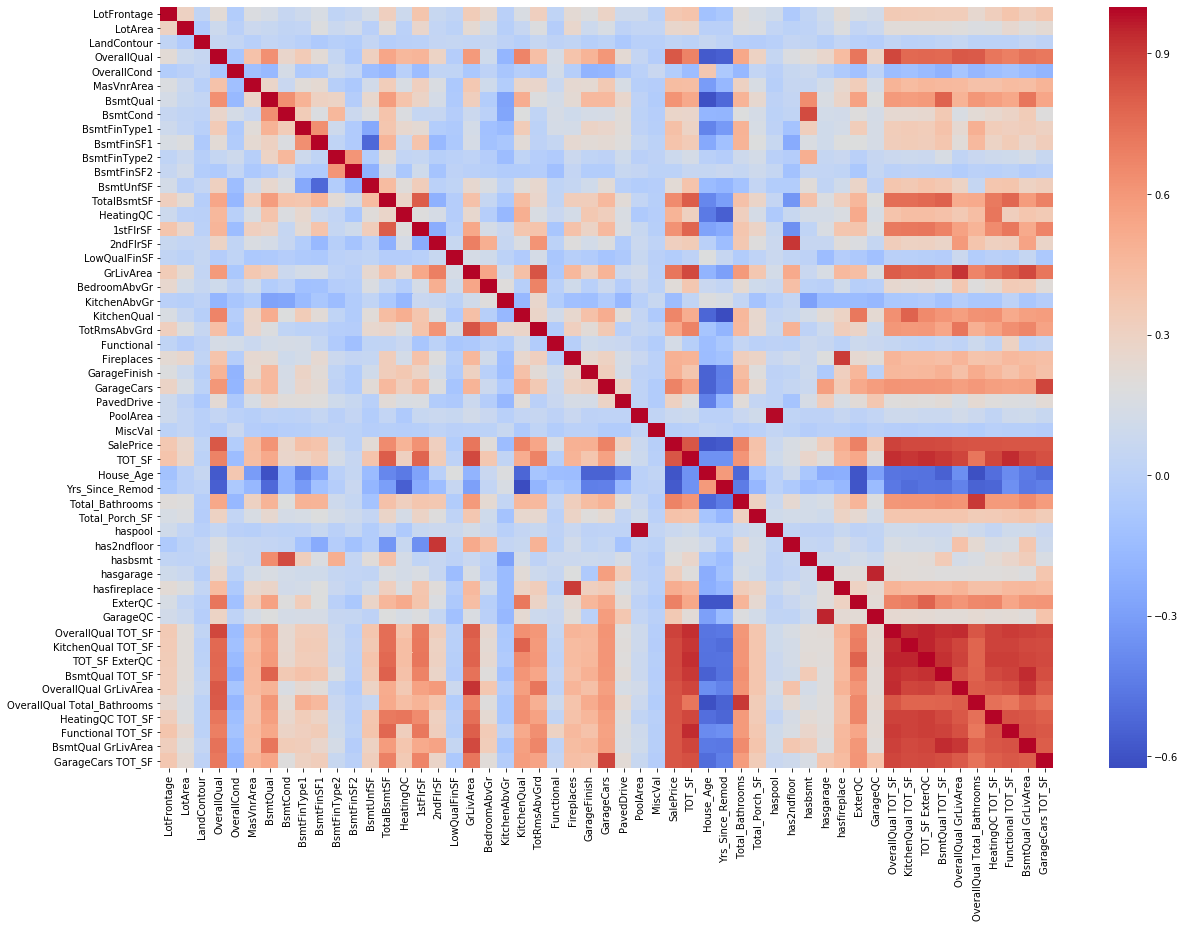

In [36]:
#View collinear features.  Revert matplotlib from 3.1.1 to 3.1.0 if squares are truncated (matplotlib bug).
fig, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(train.corr(), cmap='coolwarm')
plt.show()

### `Skew Reduction Toolkit`

In [37]:
def get_left_skew_power(df, feature, target):
    '''
    Find feature power transform with the highest correlation to target.
    The correlation is the absolute correlation between transformed 
    feature and target.
    '''
    from scipy.stats import skew

    #initialize benchmarks and results list
    targetArr = df[target].values
    origCorr = abs(np.corrcoef(df[feature].values, targetArr)[1,0])  #get absolute correlation coeff for two-set case.
    origSkew = skew(df[feature].values)
    results=[]

    #Try different powers on feature.  Record results for correlation and skew by power
    for pwr in np.arange(0.1, 10.1, 0.1):
        featArr=df[feature].values  #restore feature for next trial
        featArr = featArr**pwr
        newCorr=abs(np.corrcoef(featArr, targetArr)[0,1])  #absolute value of feature-target correlation
        newSkew = skew(featArr)     
        results.append([round(pwr,1), round(newSkew,4), round(newCorr,4)])
    results.append([1, round(origSkew,4), round(origCorr,4)])

    #Convert list to np.array.  Get the power for the highest correlation.
    resultArr=np.array(results)
    idx = np.argmax(resultArr[:,2], axis=0)   # get index of highest correlation in column 2
    #define best variables as those tied to the highest abs correlation
    bestPwr, bestSkew, bestCorr = resultArr[idx,0], resultArr[idx,1], resultArr[idx,2]
    origPwr, origSkew, origCorr = resultArr[-1,0], resultArr[-1,1], resultArr[-1,2]
    print(f'#{feature}:', 'OrigPwr, bestPwr:', origPwr, ',', bestPwr, '|', 'origSkew, bestSkew:', origSkew, ',', bestSkew, '|', 'origCorr, bestCorr:', origCorr, ',', bestCorr,'\n')
    
    if (abs(origSkew) > abs(bestSkew)) and (bestCorr > origCorr):
        return bestPwr #return best power if skew and correlation both improve
    else:
        return 1       #do nothing to feature - raise feature to 1st power

In [38]:
def lower_skew(train, test, skewness_thresh, rightFixOn=True, leftFixOn=True):
    '''
    Lower skew of numeric features.  Takes df inputs and transforms feature, lowering skew.
    Returns transformed features df and dictionary of before & after skew.  For left
    skewnes, power 2 is the default.  Higher powers may overcorrect certain features.
    '''
    from scipy.stats import skew
    from scipy.stats import boxcox
    trn=train.copy(); tst=test.copy();
    before_after={}; before_after['train']={}; before_after['test']={};        
    numeric_cols = list(trn.select_dtypes(exclude='object').columns)    
    
    for c in numeric_cols:
        skewTrnOrig = skew(trn[c])
        skewTstOrig = skew(tst[c])
        if (skewTrnOrig > skewness_thresh and rightFixOn):      #Right skew scenario.  Work with temporary series.  
            trn[c], lam = boxcox(trn[c] + 1)  #Compress right tail with boxcox log-like trransform     
            tst[c] = boxcox(tst[c] + 1, lam)
            
            if (abs(skew(trn[c])) < abs(skewTrnOrig)) and (abs(skew(tst[c])) < abs(skewTstOrig)):  #if skew improves
                train[c], lam = boxcox(train[c] + 1)
                test[c] = boxcox(test[c] + 1, lam)  #apply train feature lambda to test feature to avoid leakage
                before_after['train'][c] = [round(skewTrnOrig,2), round(skew(trn[c]),2)]
                before_after['test'][c] = [round(skewTstOrig,2), round(skew(tst[c]),2)] 
            
            else:
                print(f'{c} worse in trn or tst -- no transform applied.')
                print(f'trn orig: {round(skewTrnOrig,2)} | trn new: {round(skew(trn[c]),2)}    tst orig: {round(skewTstOrig,2)} | tst new: {round(skew(tst[c]),2)}\n')
                
        elif (skewTrnOrig < -skewness_thresh and leftFixOn):     #Left skew scenario.
            leftSkew_exp = get_left_skew_power(df=train, feature=c, target='SalePrice')
            trn[c] = (trn[c])**leftSkew_exp   #Expand right tail with squaring-like transform
            tst[c] = (tst[c])**leftSkew_exp
                
            if (abs(skew(trn[c])) < abs(skewTrnOrig)) and (abs(skew(tst[c])) < abs(skewTstOrig)):  #if skew improves
                train[c] = (train[c])**leftSkew_exp           
                test[c] = (test[c])**leftSkew_exp
                before_after['train'][c] = [round(skewTrnOrig,2), round(skew(trn[c]),2)]
                before_after['test'][c] = [round(skewTstOrig,2), round(skew(tst[c]),2)]
                                    
            else:
                print(f'{c} worse in trn or tst -- no transform applied.')
                print(f'trn orig: {round(skewTrnOrig,2)} | trn new: {round(skew(trn[c]),2)}    tst orig: {round(skewTstOrig,2)} | tst new: {round(skew(tst[c]),2)}\n')
                          
        else:   #Skew is below skewness_thresh
            continue
       
    return train, test, before_after

In [39]:
#Lower skew
train, test, before_after = lower_skew(train=train, test=test, skewness_thresh=0.5)

OverallCond worse in trn or tst -- no transform applied.
trn orig: 0.69 | trn new: 0.03    tst orig: 0.45 | tst new: -0.64

#BsmtQual: OrigPwr, bestPwr: 1.0 , 2.5 | origSkew, bestSkew: -1.2932 , 0.728 | origCorr, bestCorr: 0.6169 , 0.6739 

#BsmtCond: OrigPwr, bestPwr: 1.0 , 1.3 | origSkew, bestSkew: -3.6943 , -2.6916 | origCorr, bestCorr: 0.2745 , 0.2779 

#HeatingQC: OrigPwr, bestPwr: 1.0 , 3.1 | origSkew, bestSkew: -0.5377 , -0.2503 | origCorr, bestCorr: 0.4739 , 0.4792 

KitchenAbvGr worse in trn or tst -- no transform applied.
trn orig: 4.48 | trn new: -2.8    tst orig: 4.07 | tst new: -6.24

#Functional: OrigPwr, bestPwr: 1.0 , 1.4 | origSkew, bestSkew: -4.9655 , -4.6682 | origCorr, bestCorr: 0.1344 , 0.1346 

#PavedDrive: OrigPwr, bestPwr: 1.0 , 1.7 | origSkew, bestSkew: -3.3027 , -3.2238 | origCorr, bestCorr: 0.3047 , 0.3053 

haspool worse in trn or tst -- no transform applied.
trn orig: 15.49 | trn new: 15.49    tst orig: 15.5 | tst new: 15.5

#hasbsmt: OrigPwr, bestPwr: 1.0 

### Full X and y train data

In [40]:
#Get full X and y from train.  
train_y_full=train['SalePrice'].copy()
train_X_full=train.drop(['SalePrice'], axis='columns').copy()

#Get full X from test.
test_X_full=test.drop(['SalePrice'], axis='columns').copy()
print('train_X_full shape:',train_X_full.shape)
print('test_X_full shape:',test_X_full.shape)

train_X_full shape: (1458, 83)
test_X_full shape: (1459, 83)


[['Utilities', 0.99931, dtype('O')],
 ['Street', 0.99588, dtype('O')],
 ['PoolArea', 0.99588, dtype('float64')],
 ['PoolQC', 0.99588, dtype('O')],
 ['haspool', 0.99588, dtype('int64')],
 ['Condition2', 0.9904, dtype('O')],
 ['RoofMatl', 0.98285, dtype('O')],
 ['LowQualFinSF', 0.98217, dtype('float64')],
 ['Heating', 0.97805, dtype('O')],
 ['hasbsmt', 0.97462, dtype('int64')]]

Features where top value is big percentage of train_X_full:


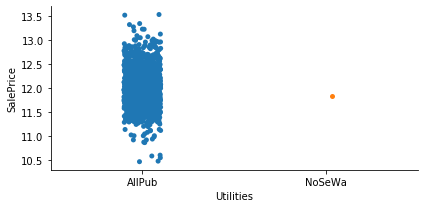

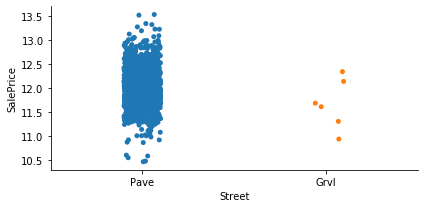

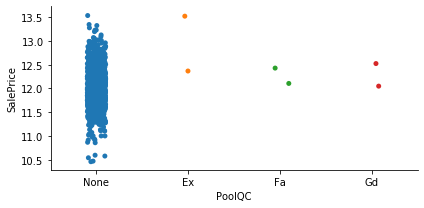

In [41]:
#Invariant features.  Explore features where most common value is most of the total.
top_val_pct=[]
for c in train_X_full.columns:
    top_val_pct.append([c, round(train_X_full[c].value_counts().values[0] / len(train_X_full),5), train_X_full[c].dtype])
display(sorted(top_val_pct, key=lambda idx: idx[1], reverse=True)[0:10])

print('Features where top value is big percentage of train_X_full:')
sns.catplot(x='Utilities',y='SalePrice', data=train, height=3, aspect=2)
sns.catplot(x='Street',y='SalePrice', data=train, height=3, aspect=2)
# fig, ax1 = plt.subplots(figsize=(6,3),constrained_layout=True)
# sns.scatterplot(x='PoolArea',y='SalePrice', data=train, ax=ax1)
sns.catplot(x='PoolQC',y='SalePrice', data=train, height=3, aspect=2)
plt.show()

#Per the charts below, drop the low information category features.  Keep the numerics which have 0.07 correl.
#PoolQC would add four dimensions with little useful data.
train_X_full.drop(['Utilities','PoolQC','Street'], axis=1, inplace=True, errors='ignore')
test_X_full.drop(['Utilities','PoolQC','Street'], axis=1, inplace=True, errors='ignore')

### Category Encode Features

In [42]:
#Copy "full" dataframes and add back SalePrice.
train_te = pd.concat([train_X_full, train_y_full], axis=1).copy()
test_te = test_X_full.copy()
test_te['SalePrice'] = np.nan

print('train_te shape:', train_te.shape)
print('test_te shape:', test_te.shape)

train_te shape: (1458, 81)
test_te shape: (1459, 81)


In [43]:
categ_cols=list(train_te.select_dtypes(include='object').columns)
print(categ_cols)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


In [44]:
train_te, test_te = target_encode_categ(encode_cols=categ_cols, train=train_te, test=test_te, target='SalePrice',\
           encoder=TargetEncoder(cols=categ_cols, min_samples_leaf=1, smoothing=1))

In [45]:
train_te.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasbsmt,hasgarage,hasfireplace,ExterQC,GarageQC,OverallQual TOT_SF,KitchenQual TOT_SF,TOT_SF ExterQC,BsmtQual TOT_SF,OverallQual GrLivArea,OverallQual Total_Bathrooms,HeatingQC TOT_SF,Functional TOT_SF,BsmtQual GrLivArea,GarageCars TOT_SF,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,12.341899,12.085945,16.395859,10.921322,12.037656,11.936101,0.643366,12.001787,12.020522,12.163647,12.042923,12.025931,12.047507,12.183269,7,5,11.984206,12.019148,12.205878,12.209636,12.163635,2.955461,12.262311,32.0,4.171168,11.955660,3,15.354127,0.761345,0.0,20.423676,279.089415,12.032052,146.827368,12.061105,12.061456,6.580219,4.508982,0.0,9.751192,3,1,4,2.448829,15.245345,0.000000,11.808915,12.160988,2,2.0,6.473008,0.0,12.058611,12.030083,0.0,12.023867,11.991068,12.00504,43.226499,2.614620,2.327016,3.5,11.134578,0,1,1,1,0,0.579032,4.655537,40.717980,17.286273,12.638592,619.110088,24.637037,5.668547,96.625251,353.769640,435.986161,190.102233,12.247699
2,12.052794,12.085945,18.567504,11.105856,12.037656,11.936101,0.643366,12.034748,12.020522,12.344166,11.816284,12.025931,12.047507,11.993690,6,8,11.984206,12.019148,11.859775,11.862293,11.896891,0.000000,11.870087,32.0,4.171168,12.369054,2,16.889170,0.761345,0.0,28.284506,381.336746,12.032052,146.827368,12.061105,12.061456,6.947753,0.000000,0.0,9.247174,3,1,3,2.141600,15.245345,0.608257,12.186421,12.160988,2,2.0,6.473008,0.0,12.058611,12.030083,0.0,11.991498,11.991068,12.00504,42.956684,7.472386,5.854560,2.5,23.838177,0,0,1,1,1,0.559422,4.655537,38.888363,16.347966,12.120886,612.493430,22.242904,4.453320,95.996654,350.638114,358.936258,188.386732,12.109016


### One-Hot Encoding Categorical Features

###### `One-Hot Categorical Features function`

In [46]:
categ_cols=list(train_X_full.select_dtypes(include='object').columns)
print(categ_cols)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


In [47]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

#One-Hot Encode full train and test.
ohe_train_df, ohe_test_df = one_hot_encode(train_df=train_X_full, test_df=test_X_full, cat_cols=categ_cols)

In [48]:
#Drop original category columns.  Add OHE category columns.
train_X_full = train_X_full.drop(columns=categ_cols, axis='columns', errors='ignore')
test_X_full = test_X_full.drop(columns=categ_cols, axis='columns', errors='ignore')

train_X_full = pd.concat([train_X_full, ohe_train_df], axis='columns')
test_X_full = pd.concat([test_X_full, ohe_test_df], axis='columns')

In [49]:
#Check train and test columns mismatch
train_X_full_col = set(list(train_X_full.columns))
test_X_full_col = set(list(test_X_full.columns))

test_X_full_col-train_X_full_col

set()

### 49 Noise Features at 0.995 pct zeros cutoff:  ###

Count nonzero - 6 :


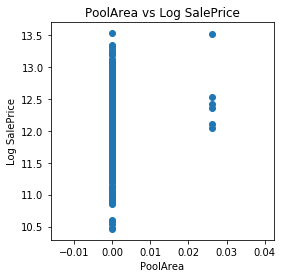

Count nonzero - 6 :


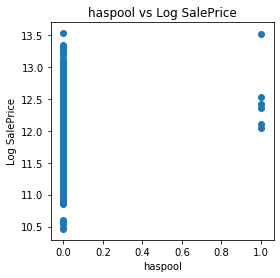

Count nonzero - 4 :


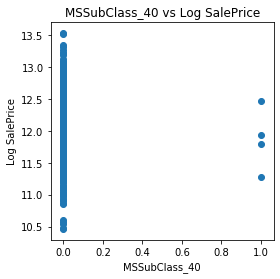

Count nonzero - 4 :


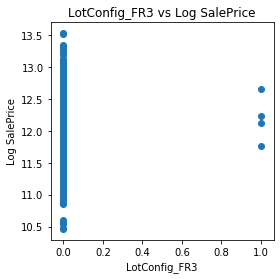

Count nonzero - 2 :


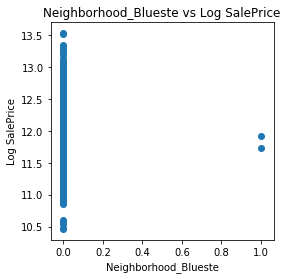

Count nonzero - 2 :


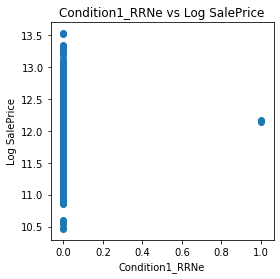

Count nonzero - 5 :


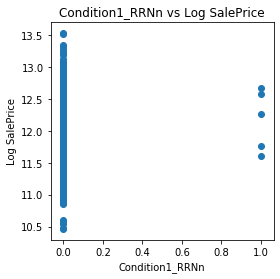

Count nonzero - 2 :


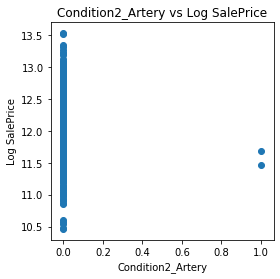

Count nonzero - 6 :


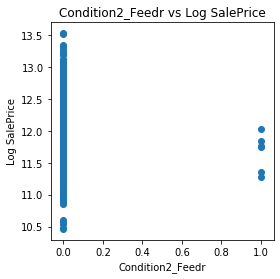

Count nonzero - 1 :


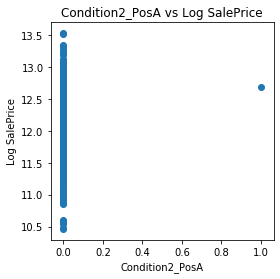

Count nonzero - 1 :


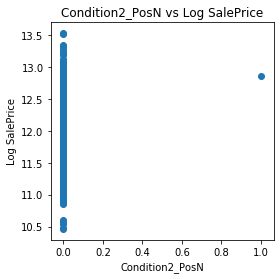

Count nonzero - 1 :


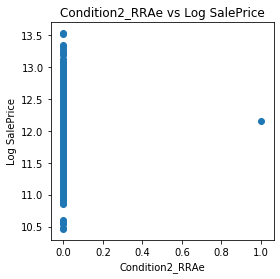

Count nonzero - 1 :


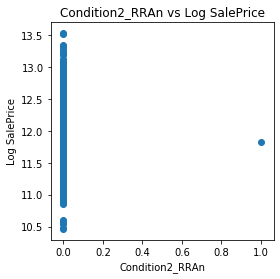

Count nonzero - 2 :


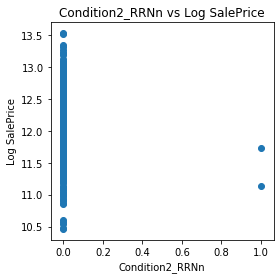

Count nonzero - 7 :


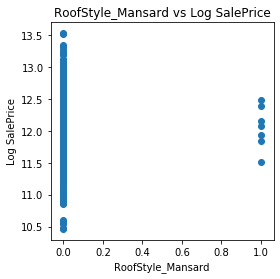

Count nonzero - 2 :


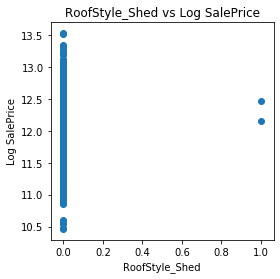

Count nonzero - 1 :


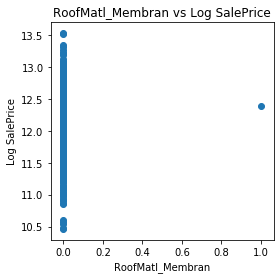

Count nonzero - 1 :


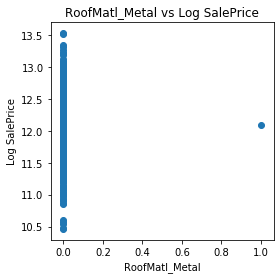

Count nonzero - 1 :


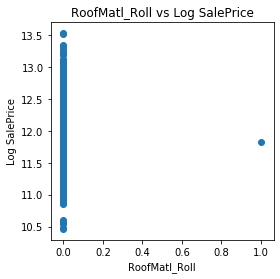

Count nonzero - 5 :


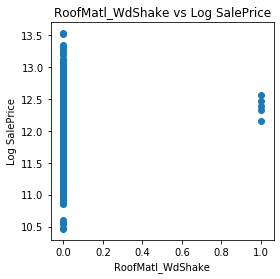

Count nonzero - 6 :


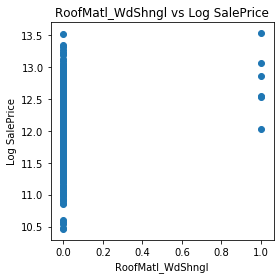

Count nonzero - 1 :


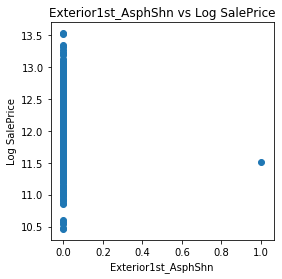

Count nonzero - 2 :


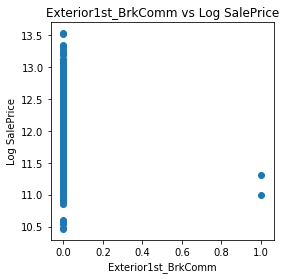

Count nonzero - 1 :


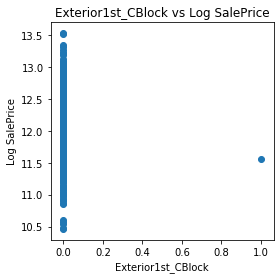

Count nonzero - 1 :


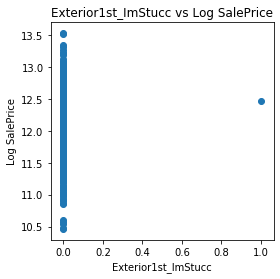

Count nonzero - 2 :


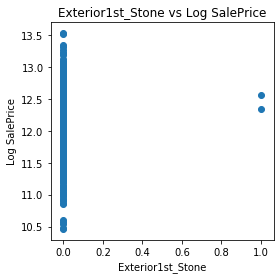

Count nonzero - 3 :


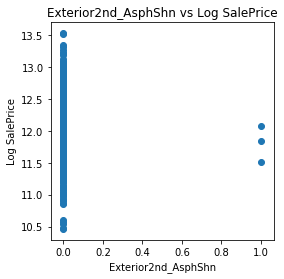

Count nonzero - 7 :


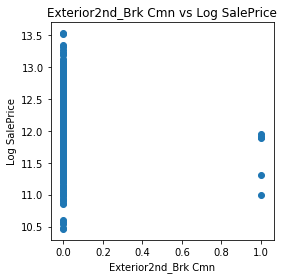

Count nonzero - 1 :


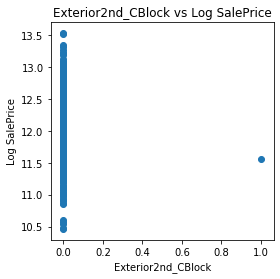

Count nonzero - 1 :


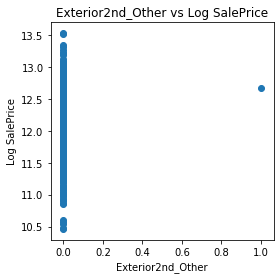

Count nonzero - 5 :


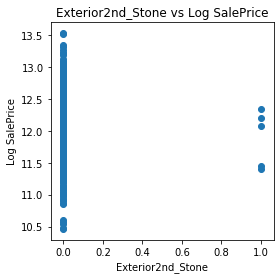

Count nonzero - 6 :


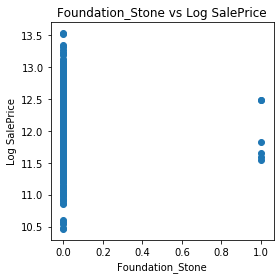

Count nonzero - 3 :


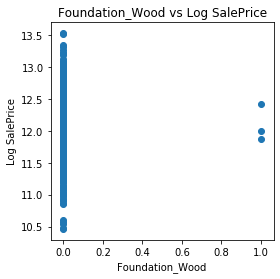

Count nonzero - 1 :


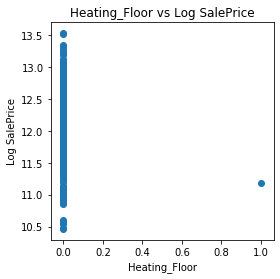

Count nonzero - 7 :


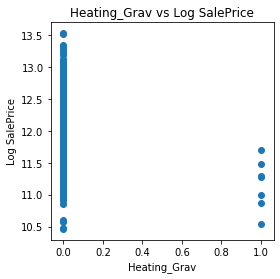

Count nonzero - 2 :


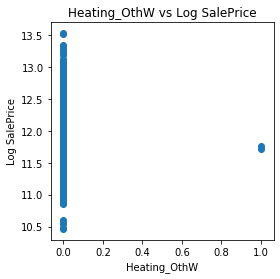

Count nonzero - 4 :


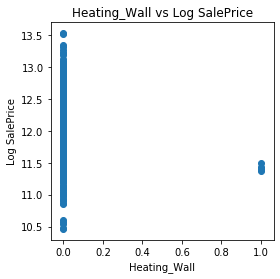

Count nonzero - 3 :


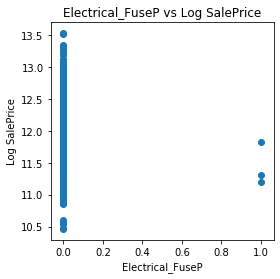

Count nonzero - 1 :


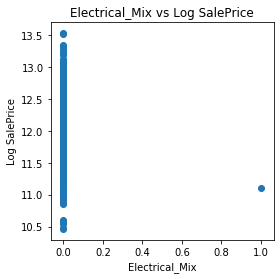

Count nonzero - 6 :


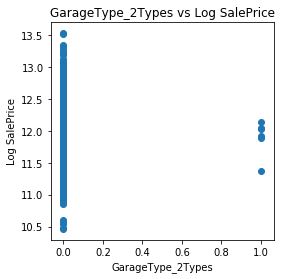

Count nonzero - 2 :


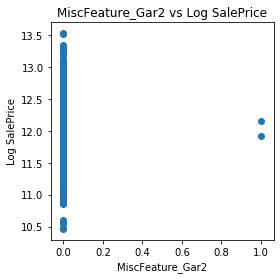

Count nonzero - 2 :


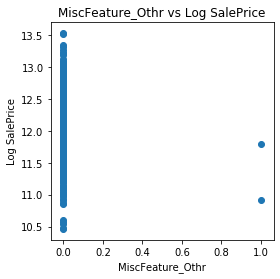

Count nonzero - 1 :


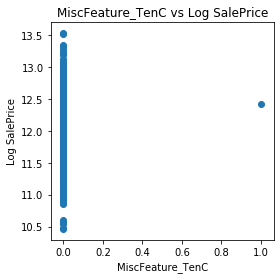

Count nonzero - 4 :


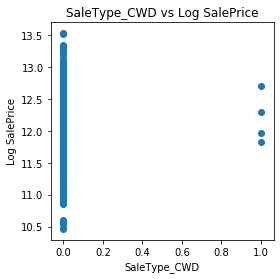

Count nonzero - 2 :


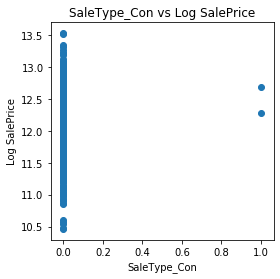

Count nonzero - 5 :


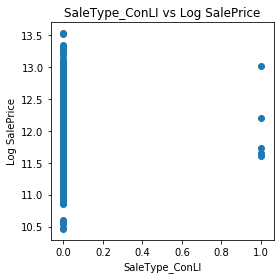

Count nonzero - 5 :


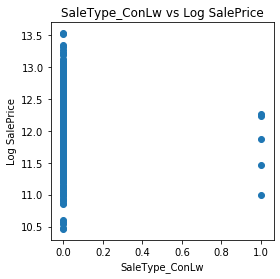

Count nonzero - 3 :


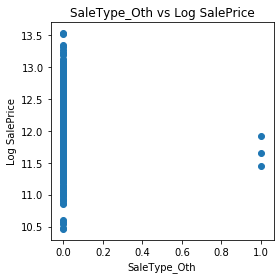

Count nonzero - 4 :


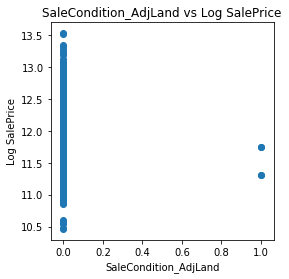

In [50]:
#Review noise features - where one category is nearly all observations.
noise_feat = []
pct_zeros = .995
for i in train_X_full.columns:
    counts = train_X_full[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(train_X_full) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###\n')

for c in noise_feat:
    counts = train_X_full[c].value_counts()
    zeros = counts.iloc[0]  #top frequency category
    print('Count nonzero -', (len(train_X_full[c]) - zeros),':')
    plt.figure(figsize=[4,4])
    plt.scatter(train_X_full[c], train_y_full)
    plt.title(f'{c} vs Log SalePrice'); plt.xlabel(f'{c}'); plt.ylabel('Log SalePrice');
    plt.show()   

In [51]:
# #Drop noise features.  Will help non-regularized models by reducing dimensionality.
train_X_full = train_X_full.drop(columns=noise_feat, axis='columns', errors='ignore')
test_X_full = test_X_full.drop(columns=noise_feat, axis='columns', errors='ignore')

### Feature Selection with Recursive Feature Elimination (RFE)

In [52]:
from sklearn.feature_selection import RFECV
orig_feat = np.array(train_X_full.columns)
metrics=[]

for alpha in [0.1,1,15,25]:
    rfecv = RFECV(estimator=Ridge(alpha=alpha), step=1, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    rfecv.fit(train_X_full,train_y_full)
    metrics.append([alpha, rfecv.n_features_,min(rfecv.grid_scores_), orig_feat[~rfecv.support_]])
    
metric=pd.DataFrame(data=metrics, columns=['alpha','optimal_feat', 'min_MSE', 'drop_feat'])
display(metric)
RFE_drops = metric.loc[2,'drop_feat']
print('Chosen drop features:', RFE_drops)

#Drop RFE features.
train_X_full = train_X_full.drop(columns=RFE_drops, axis='columns', errors='ignore')
test_X_full = test_X_full.drop(columns=RFE_drops, axis='columns', errors='ignore')

,alpha,optimal_feat,min_MSE,drop_feat
0,0.1,202,-0.116886,"[TotalBsmtSF, HeatingQC, BsmtQual TOT_SF, Bsmt..."
1,1.0,198,-0.154338,"[BsmtCond, TotalBsmtSF, HeatingQC, BsmtQual TO..."
2,15.0,197,-0.062467,"[TotalBsmtSF, HeatingQC, LowQualFinSF, ExterQC..."
3,25.0,196,-0.055155,"[TotalBsmtSF, HeatingQC, ExterQC, BsmtQual TOT..."


Chosen drop features: ['TotalBsmtSF' 'HeatingQC' 'LowQualFinSF' 'ExterQC' 'BsmtQual TOT_SF'
 'BsmtQual GrLivArea' 'GarageCars TOT_SF' 'MSSubClass_45'
 'Neighborhood_SWISU' 'FireplaceQu_Gd']


In [53]:
#Count of dropped features.
len(orig_feat[~rfecv.support_])

11

In [54]:
def get_PCA(train, test):
    '''
    Takes numeric dataframe and returns principal components dataframes with the
    same shape, indices, and numbered column names.
    '''
    pca = PCA(n_components=None)
    trainPC = pca.fit_transform(train)  #get train PC
    trainPC = pd.DataFrame(trainPC, index=train.index).add_prefix('PC')
    trnCumSum=np.cumsum(pca.explained_variance_ratio_)
    testPC = pca.transform(test)        #test is projected on the PCs previously extracted from train
    testPC = pd.DataFrame(testPC, index=test.index).add_prefix('PC')
    return trainPC, testPC, trnCumSum

In [55]:
# # ****PCA Transform the data****

# #Get all principal components of train and apply same transformation to test.
# train_X_full, test_X_full, trnCumSum = get_PCA(train_X_full, test_X_full)
# trnCumSum[0:174]

# #keep 101 principal components
# train_X_full.drop(train_X_full.iloc[0,175:].index, axis='columns', inplace=True, errors='ignore')
# test_X_full.drop(test_X_full.iloc[0,175:].index, axis='columns', inplace=True, errors='ignore')

# #print reduced dimensions
# print('train_X_full:', train_X_full.shape)
# print('test_X_full:', test_X_full.shape)
# display(train_X_full.head(2))
# display(test_X_full.head(2))

In [56]:
def plot_learn_curve(model, X, y, step):
    '''
    Assess model generalization performance: underfit, overfit.
    '''
    trn_X, valid_X, trn_y, valid_y = train_test_split(X, y, test_size=0.20, random_state=50, shuffle=True)
    trn_error, valid_error, set_size = [], [], []
    for obs in range(1, len(trn_X),step):
        set_size.append(obs)
        model.fit(trn_X.iloc[:obs], trn_y.iloc[:obs])  #fit on train subset
        trn_pred = model.predict(trn_X.iloc[:obs])     #predict on train subset
        valid_pred = model.predict(valid_X)            #predict on valid set
        trn_error.append(round(np.sqrt(mean_squared_error(trn_y.iloc[:obs], trn_pred)), 6))
        valid_error.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 6))
    plt.plot(set_size, trn_error,  'rx', linewidth=2, label='train')
    plt.plot(set_size, valid_error, 'bx', linewidth=2, label='valid')
    plt.title('Learning Curve - Error by Set Size:')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()

## Cross-Validation

### `Set aside holdout data from train`

In [57]:
#Set aside holdout data from train
from sklearn.model_selection import train_test_split
train_X, holdout_X, train_y, holdout_y = train_test_split(train_X_full, train_y_full, test_size=0.20,random_state=11, shuffle=True)

In [58]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_mse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):                         #split train data excluding holdout
        #Clone is copy of model not yet fit on any data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_mse.append(round(mean_squared_error(valid_y, valid_pred), 6))
    return fold_mse, clone_model

In [59]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=True)
fold_mse, linMod = train_and_valid(what_model=lr, num_folds=10, X=train_X, y=train_y)
print('Fold MSE:', fold_mse)
print('## Avg MSE:', round(np.mean(fold_mse),5),'+-', round(np.std(fold_mse),5))
print('## LR R^2:', round(linMod.score(train_X, train_y),3))

#Score holdout
holdout_pred = linMod.predict(holdout_X)
print('\n## holdout MSE:', round(mean_squared_error(holdout_y, holdout_pred), 5))
print('## holdout LR R^2:', round(linMod.score(holdout_X, holdout_y),4))

Fold MSE: [0.017931, 0.010375, 0.010058, 0.010076, 0.010229, 0.01001, 0.016078, 0.007876, 0.011714, 0.015417]
## Avg MSE: 0.01198 +- 0.00313
## LR R^2: 0.952

## holdout MSE: 0.01893
## holdout LR R^2: 0.8743


In [60]:
#Train and Score Ridge CV
ridge=Ridge(alpha=15, solver='cholesky')
fold_mse, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=train_X, y=train_y)
print('Fold MSE:', fold_mse)
print('## Avg MSE:', round(np.mean(fold_mse),5),'+-', round(np.std(fold_mse),5))
print('## LR R^2:', round(ridgeMod.score(train_X, train_y),3))

#Score holdout
holdout_pred = ridgeMod.predict(holdout_X)
print('\n## holdout MSE:', round(mean_squared_error(holdout_y, holdout_pred), 5))
print('## holdout LR R^2:', round(ridgeMod.score(holdout_X, holdout_y),4))

Fold MSE: [0.024901, 0.008301, 0.009449, 0.011388, 0.011146, 0.009632, 0.013691, 0.007885, 0.008194, 0.014479]
## Avg MSE: 0.01191 +- 0.00483
## LR R^2: 0.943

## holdout MSE: 0.01454
## holdout LR R^2: 0.9034


#### LightGBM CV with Target Encoded Data

#### `Set aside holdout data from train`

In [61]:
#Split out SalePrice for LightGBM.
train_X_te = train_te.copy()
train_y_te = train_X_te.pop('SalePrice')

tstX = test_te.drop(['SalePrice'], axis=1, errors='ignore')

#Set aside holdout data from train_te
trnX, holdX, trny, holdy = train_test_split(train_X_te, train_y_te, test_size=0.20,random_state=11, shuffle=True)

In [ ]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600),
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfittinga
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=10, n_jobs=-1, refit=True,\
                           scoring='neg_mean_squared_error', return_train_score=False,random_state=5)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trnX, trny)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],5)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {-lgb_model.best_score_:.5f} +- {best_score_std:.5f}','\n')   
print('## Best parameters:')
best_par = lgb_model.best_params_      
pprint.pprint(best_par)
      
#Save off train predictions for residuals
y_trn_pred = lgb_model.predict(trnX)
      
#Score holdout
holdout_pred = lgb_model.predict(holdX)
print('\n## holdout MSE:', round(mean_squared_error(holdy, holdout_pred), 5))
print('## holdout R^2:', round(r2_score(holdy, holdout_pred),4))

### `Train Final LightGBM on Full Data`

In [ ]:
#Train LightGBM on full data with best parameters.
lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1,**best_par)
lgb_best.fit(train_X_te, train_y_te)

### `Train Final Ridge on Full Data`

In [ ]:
from sklearn.metrics import mean_squared_error
rr=Ridge(alpha=15, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(train_X_full, train_y_full)

In [ ]:
#Assess FINAL overfit/underfit
plot_learn_curve(model = rr, X=train_X_full, y=train_y_full, step=30)

In [ ]:
#View Ridge coefficients.
for i in zip(train_X_full.columns, np.round(rr.coef_,4)):
    print(i)

#### Do Kaggle Predictions

In [ ]:
#LightGBM with Target Encoding.

#Predict test and inverse normalize prediction.
test_pred=lgb_best.predict(tstX)
test_pred=np.exp(test_pred)-1
test_pred[0:5]

In [ ]:
#Kaggle Submission - Index 1461 - 2919
submission_df=pd.DataFrame({'Id':tstX.index, 'SalePrice':test_pred})
submission_df.to_csv('submissions/submission_02-14-2020_1.csv', index=False)

#### Result: Kaggle Score in Log RMSE - 0.11717

##### **Leaderboard: Top 20%**

## TO DO:

In [ ]:
end1 = time.time()
print(f'Model runtime is {(end1-start1)/60:.3f} minutes.')

### Build Automated Pipeline:

In [ ]:
# #Get category and numeric column names
# cat_cols = list(train_X.select_dtypes(include='object').columns)
# num_cols = list(train_X.select_dtypes(exclude='object').columns)

# #Use ColumnTransformer to combine numeric and category pipes.
# #Create another pipe combining this pipe with estimator model.

# #Categorical.  Imputer 'constant' replaces missing with fill value.
# si = SimpleImputer(strategy='constant', fill_value='None')
# #for test, ignore data exclusive to train by zero-encoding
# ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# #In Pipeline, list out steps as [(stepname, transform),()..]
# cat_pipe=Pipeline([('impute', si), ('ohe', ohe)])  #pipe

# #Numeric
# si = SimpleImputer(strategy='median')
# ss = StandardScaler()
# num_pipe = Pipeline([('impute', si), ('scale', ss)])

# #Combine ct pipelines with (pipename, pipemodel, target_cols)
# ct = ColumnTransformer([('cat_pipe', cat_pipe, cat_cols),
#                        ('num_pipe', num_pipe, num_cols)])

# #Add Estimator models
# lr=LinearRegression(fit_intercept=True)
# ls = Lasso(alpha=0.005)
# rr=Ridge(alpha=1)

# #In final pipe, connect ct pipeline with estimator model.
# final_pipe = Pipeline([('ct', ct), ('estimator', lr)])